<a href="https://colab.research.google.com/github/LaizaCostaa/sistema_de_recomendacao_ze_delivery/blob/main/sistema_de_recomendacao_ze_delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [147]:
# Local onde os arquivos estão armazenados no Google Drive
users_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_products.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_interactions - user_interactions_1000.csv')

# PRÉ-PROCESSAMENTO DOS DADOS





In [148]:
print(users_df.head())
print(products_df.head())
print(interactions_df.head())

   user_id  age gender            location signup_date
0        1   58      M       São Paulo, SP  2022-10-31
1        2   65      F  Rio de Janeiro, RJ  2024-07-05
2        3   32      M          Recife, PE  2024-02-01
3        4   24  Outro          Recife, PE  2023-11-20
4        5   52      M    Porto Alegre, RS  2023-06-17
   product_id     product_name      category  price      brand  \
0           1       Skol 255ml       Cerveja    8.5       Skol   
1           2  Coca-Cola 293ml  Refrigerante    9.0  Coca-Cola   
2           3   Heineken 426ml       Cerveja    9.5   Heineken   
3           4      Pepsi 207ml       Cerveja    8.0      Pepsi   
4           5  Coca-Cola 448ml  Refrigerante    9.0  Coca-Cola   

   alcohol_content  
0              4.5  
1              0.0  
2              5.0  
3              4.5  
4              0.0  
   user_id  product_id interaction_type               interaction_time  rating
0       21          48         cart_add  2022-03-25 07:16:45.4054054

In [149]:
# Remover valores NaN nas interações
interactions_df.dropna(subset=['rating'], inplace=True)

# Normalizar as avaliações
interactions_df['rating_normalized'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

In [150]:
interactions_df.dropna(subset=['rating'], inplace=True)
interactions_df['rating_normalized'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

In [151]:
print(interactions_df.head())

   user_id  product_id interaction_type               interaction_time  \
0       21          48         cart_add  2022-03-25 07:16:45.405405405   
1       16           7             view  2022-09-22 03:49:11.351351352   
2       43          39             view  2023-10-14 01:56:45.405405408   
3       63          13         purchase  2022-03-23 02:40:00.000000000   
4        8          24         cart_add  2023-03-29 16:30:16.216216216   

   rating  rating_normalized  
0     3.0                0.5  
1     3.0                0.5  
2     3.0                0.5  
3     1.0                0.0  
4     3.0                0.5  


In [123]:
''''# Gerar dados fictícios
num_fictitious_interactions = 1000  # Número de dados fictícios que você deseja criar

# Criar IDs aleatórios para usuários e produtos
fake_user_ids = np.random.choice(users_df['user_id'], num_fictitious_interactions)
fake_product_ids = np.random.choice(products_df['product_id'], num_fictitious_interactions)

# Criar avaliações fictícias (por exemplo, de 1 a 5)
fake_ratings = np.random.randint(1, 6, size=num_fictitious_interactions)

# Criar um DataFrame de interações fictícias
fake_interactions_df = pd.DataFrame({
    'user_id': fake_user_ids,
    'product_id': fake_product_ids,
    'rating': fake_ratings
})

# Visualizar os dados fictícios
print(fake_interactions_df.head())

   user_id  product_id  rating
0       42          29       4
1       31           5       3
2       40           7       4
3       63          42       5
4       89          31       1


In [124]:
''''# Combinar dados reais com dados fictícios
combined_interactions_df = pd.concat([interactions_df, fake_interactions_df], ignore_index=True)

# Visualizar o DataFrame combinado
print(combined_interactions_df.head())

   user_id  product_id interaction_type     interaction_time  rating  \
0       27          28         purchase  2024-01-07 22:04:29     5.0   
1       57          29         purchase  2024-08-07 23:48:16     2.0   
2       66          31         purchase  2024-01-04 04:14:36     2.0   
3       66          43         purchase  2024-07-13 12:35:17     5.0   
4       59          27         purchase  2024-08-21 16:10:02     5.0   

   rating_normalized  
0               1.00  
1               0.25  
2               0.25  
3               1.00  
4               1.00  


In [125]:
''''from sklearn.model_selection import train_test_split

# Dividir os dados combinados em treinamento e teste
train_data, test_data = train_test_split(combined_interactions_df, test_size=0.2, random_state=42)

# Visualizar os dados de treinamento e teste
print(f"Tamanho do conjunto de treino: {len(train_data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")

Tamanho do conjunto de treino: 884
Tamanho do conjunto de teste: 221


# CÁLCULO DE SIMILARIDADE ENTRE USUÁRIOS E PRODUTOS

In [152]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np


In [153]:
# Criar a matriz de interações
user_product_matrix = interactions_df.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

# Fatoração da matriz com SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_product_matrix)
product_factors = svd.components_.T

# Similaridade de usuários
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_factors)

# Similaridade de produtos
products_df['category_brand'] = products_df['category'] + " " + products_df['brand']
product_features = pd.get_dummies(products_df['category_brand'])
product_similarity = cosine_similarity(product_features)

In [154]:
# Filtrar os produtos comuns entre a matriz de interações e a matriz de similaridade de produtos
common_product_ids = user_product_matrix.columns.intersection(products_df['product_id'])

# Atualizar a matriz de interações para incluir apenas os produtos em comum
user_product_matrix = user_product_matrix[common_product_ids]

# Atualizar as características dos produtos para garantir que estejam alinhadas
product_features = product_features.loc[products_df['product_id'].isin(common_product_ids)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity = cosine_similarity(product_features)


* Funcao implementada com sucesso, combinando a
similaridade de usuários e produtos para gerar recomendações personalizadas.
* O modelo balanceia os dois aspectos (usuário e produto), permitindo ajustar o peso de cada um para melhorar a precisão das recomendações.



Em casos futuros pode ser interessante ajustar esses pesos para focar mais na similaridade de usuários ou de produtos.

# FUNÇÃO DE RECOMENDAÇÃO HÍBRIDA

In [155]:

def recommend_hybrid(user_id, n_recommendations=5):
    # Similaridade do usuário com outros usuários
    similar_users = user_similarity[user_id - 1]  # Ajustando o índice

    # Similaridade de produtos com base nas avaliações do usuário
    user_ratings = user_product_matrix.loc[user_id]

    # Certificar que as dimensões estão alinhadas
    similar_products = product_similarity.dot(user_ratings)

    # Combinação ponderada entre similaridade de usuários e produtos
    hybrid_score = 0.5 * similar_users.dot(user_product_matrix) + 0.5 * similar_products

    # Ordenar os produtos com maior pontuação
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids[recommended_products]

    # Retornar os produtos recomendados
    return products_df[products_df['product_id'].isin(recommended_product_ids)]

# Exemplo de recomendação para o usuário de ID 1
recommendations = recommend_hybrid(user_id=1, n_recommendations=5)
print(recommendations[['product_name', 'category', 'brand']])


          product_name      category     brand
0           Skol 255ml       Cerveja      Skol
5       Heineken 284ml       Cerveja  Heineken
13      Heineken 414ml       Cerveja  Heineken
20  Água Crystal 470ml       Cerveja      Água
34  Água Crystal 327ml  Refrigerante      Água


In [156]:
# Função de recomendação ajustada para verificar os IDs dos produtos recomendados
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids_train[recommended_products]


    print(f"Produtos recomendados para o usuário {user_id}: {recommended_product_ids}")

    # merge com o DataFrame de produtos para retornar as informações detalhadas
    recommendations = products_df[products_df['product_id'].isin(recommended_product_ids)]

    # Garantir que as colunas 'product_name', 'category', e 'brand' estão presentes
    return recommendations[['product_name', 'category', 'brand']]


# AVALIAÇÃO DO MODELO




In [157]:
from sklearn.model_selection import train_test_split


In [158]:
# Dividindo o conjunto de interações em treino (80%) e teste (20%)
train_data, test_data = train_test_split(interactions_df, test_size=0.2, random_state=42)

In [159]:
# matriz de interações para o conjunto de treino
user_product_matrix_train = train_data.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

In [160]:
# Calculando a similaridade de usuários com base no conjunto de treino
user_similarity_train = cosine_similarity(user_product_matrix_train)

# Filtrar os produtos comuns entre a matriz de interações de treino e os produtos
common_product_ids_train = user_product_matrix_train.columns.intersection(products_df['product_id'])
product_features_train = product_features.loc[products_df['product_id'].isin(common_product_ids_train)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity_train = cosine_similarity(product_features_train)

In [161]:
from sklearn.metrics import mean_squared_error

In [162]:
#Criar um mapeamento do `user_id` para o índice da matriz de similaridade
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_product_matrix_train.index)}

In [163]:
# Função de recomendação com base no conjunto de treino ajustada com pesos personalizados
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados
    recommended_product_ids = common_product_ids_train[recommended_products]

    return products_df[products_df['product_id'].isin(recommended_product_ids)]

In [164]:
user_ratings

,product_id,product_name,category,price,brand,alcohol_content,category_brand
12,13,Pepsi 326ml,Energético,10.0,Pepsi,0.0,Energético Pepsi
19,20,Coca-Cola 478ml,Refrigerante,9.0,Coca-Cola,0.0,Refrigerante Coca-Cola
20,21,Água Crystal 470ml,Cerveja,5.0,Água,5.0,Cerveja Água
21,22,Heineken 268ml,Refrigerante,9.0,Heineken,0.0,Refrigerante Heineken
48,49,Coca-Cola 540ml,Refrigerante,9.0,Coca-Cola,0.0,Refrigerante Coca-Cola


# **VALIDAÇÃO CRUZADA**

In [165]:
# Função para avaliação do modelo usando validação cruzada
def evaluate_model(k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(user_product_matrix):
        train_data = user_product_matrix.iloc[train_index]
        test_data = user_product_matrix.iloc[test_index]

        # Filtrar os produtos que estão presentes em ambos os conjuntos
        common_product_ids = train_data.columns.intersection(product_features.index)

        # Calcular a similaridade com base no treino
        user_similarity_train = cosine_similarity(train_data[common_product_ids])
        product_similarity_train = cosine_similarity(product_features.loc[common_product_ids])

        for user_id in test_data.index:
            for product_id in common_product_ids:
                if user_id in train_data.index and product_id in train_data.columns:
                    user_ratings = recommend_hybrid(user_id, n_recommendations=5)
                    if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                        predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
                    else:
                        predicted_rating = 0
                    actual_rating = test_data.loc[user_id, product_id]
                    rmse_scores.append(mean_squared_error([actual_rating], [predicted_rating], squared=False))

    return np.mean(rmse_scores)

# Avaliação do modelo
rmse = evaluate_model()
print(f"RMSE médio: {rmse:.4f}")

RMSE médio: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [166]:
# Função para avaliação do modelo usando validação cruzada
def evaluate_model(k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, test_index in kf.split(user_product_matrix):
        train_data = user_product_matrix.iloc[train_index]
        test_data = user_product_matrix.iloc[test_index]

        # Calcular a similaridade com base no treino
        user_similarity_train = cosine_similarity(train_data)
        product_similarity_train = cosine_similarity(product_features.loc[train_data.columns])

        for user_id in test_data.index:
            for product_id in test_data.columns:
                if user_id in train_data.index and product_id in train_data.columns:
                    user_ratings = recommend_hybrid(user_id, n_recommendations=5)
                    if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                        predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
                    else:
                        predicted_rating = 0
                    actual_rating = test_data.loc[user_id, product_id]
                    rmse_scores.append(mean_squared_error([actual_rating], [predicted_rating], squared=False))

    return np.mean(rmse_scores)

In [167]:
# Avaliação do modelo
rmse = evaluate_model()
print(f"RMSE médio: {rmse:.4f}")

# Função para visualização de recomendações
def plot_recommendations(user_id, n_recommendations=5):
    recommendations = recommend_hybrid(user_id, n_recommendations)
    if recommendations.empty:
        print(f"Nenhuma recomendação disponível para o usuário {user_id}")
    else:
        category_counts = recommendations['category'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values)
        plt.title(f"Recomendações por Categoria para o Usuário {user_id}")
        plt.xlabel("Categoria")
        plt.ylabel("Número de Produtos Recomendados")
        plt.xticks(rotation=45)
        plt.show()

KeyError: '[50] not in index'

In [ ]:
# Exemplo de recomendação e visualização
plot_recommendations(user_id=2)

# CÁLCULO DO RMSE

In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
test_data['rating_normalized'] = (test_data['rating'] - test_data['rating'].min()) / (test_data['rating'].max() - test_data['rating'].min())

In [106]:
predicted_rating = user_ratings[user_ratings['product_id'] == product_id].get('rating_normalized', pd.Series([0])).values[0]


In [107]:
predicted_ratings = []
actual_ratings = []

for _, row in test_data.iterrows():
    user_id = row['user_id']
    product_id = row['product_id']

    # Verificar se o usuário e o produto existem no conjunto de treino
    if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
        user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

        # Verificação de user_ratings para garantir que a coluna 'rating_normalized' exista
        print(f"User Ratings for User {user_id}:")
        print(user_ratings.head())  # Inspecionar a estrutura de user_ratings

        # Prevendo a avaliação com base no score do produto recomendado
        if not user_ratings.empty and product_id in user_ratings['product_id'].values:
            if 'rating_normalized' in user_ratings.columns:
                predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
            else:
                print(f"Coluna 'rating_normalized' não encontrada para o user_id {user_id}.")
                predicted_rating = 0  # Valor padrão caso a coluna não exista
        else:
            predicted_rating = 0  # Se o produto não for recomendado, prever como 0

        predicted_ratings.append(predicted_rating)
        actual_ratings.append(row['rating_normalized'])

# Calcular o RMSE para medir o desempenho do modelo
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"RMSE do modelo: {rmse:.4f}")

User Ratings for User 76:
    product_id    product_name      category  price     brand  \
8            9    Brahma 229ml       Cerveja    8.5    Brahma   
12          13     Pepsi 326ml    Energético   10.0     Pepsi   
18          19    Brahma 378ml       Cerveja    9.5    Brahma   
21          22  Heineken 268ml  Refrigerante    9.0  Heineken   
37          38    Brahma 314ml       Cerveja    9.5    Brahma   

    alcohol_content         category_brand  
8               4.5         Cerveja Brahma  
12              0.0       Energético Pepsi  
18              4.5         Cerveja Brahma  
21              0.0  Refrigerante Heineken  
37              4.5         Cerveja Brahma  
User Ratings for User 54:
    product_id        product_name      category  price      brand  \
20          21  Água Crystal 470ml       Cerveja    5.0       Água   
23          24          Skol 304ml       Cerveja    8.5       Skol   
30          31  Água Crystal 252ml  Refrigerante    5.0       Água   
34     

O modelo foi treinado e avaliado usando a métrica RMSE (Root Mean Square Error), que mede o erro entre as predições do modelo e as avaliações reais dos usuários.
* Um RMSE de 0.6072 indica que o modelo é razoavelmente preciso em suas recomendações, mas ainda pode ser otimizado.

 Consideração:
* O RMSE é uma boa métrica para avaliar a precisão, mas não é a única. Também pode ser interessante analisar o modelo com outras métricas, como precisão, recall ou F1-score.
* Além disso, avaliar a qualidade das recomendações de forma qualitativa (se os produtos são realmente relevantes) também é importante.

ValueError: Index contains duplicate entries, cannot reshape

In [75]:
# Carregar dados
ratings_df = load_data_from_sheet()

# Gerar e adicionar dados fictícios
# [Código para gerar dados fictícios aqui]

# Combinar os dados
combined_ratings_df = pd.concat([ratings_df, ratings_df_ficticios], ignore_index=True)

# Dividir os dados em folds
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(combined_ratings_df):
    train_data = combined_ratings_df.iloc[train_index]
    test_data = combined_ratings_df.iloc[test_index]
    # Treinar e avaliar o modelo

NameError: name 'load_data_from_sheet' is not defined

In [73]:
# Loop de validação cruzada
for train_index, test_index in kf.split(user_product_matrix_train):
    train_data = user_product_matrix_train.iloc[train_index]
    test_data = user_product_matrix_train.iloc[test_index]

    predicted_ratings = []
    actual_ratings = []

    # Iterar sobre os índices e colunas (user_id e product_id)
    for user_id in test_data.index:  # Itera sobre cada user_id
        for product_id in test_data.columns:  # Itera sobre cada product_id

            # Verificar se o usuário e o produto existem no conjunto de treino
            if user_id in train_data.index and product_id in train_data.columns:
                user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

                # Prevendo a avaliação com base no score do produto recomendado
                if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                    if 'rating_normalized' in user_ratings.columns:
                        predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
                    else:
                        predicted_rating = 0  # Valor padrão caso a coluna não exista
                else:
                    predicted_rating = 0  # Se o produto não for recomendado, prever como 0

                predicted_ratings.append(predicted_rating)
                actual_ratings.append(test_data.loc[user_id, product_id])  # Avaliação real

    # Adiciona uma verificação para evitar erro de lista vazia
    if actual_ratings and predicted_ratings:
        # Calcular o RMSE para o fold atual
        fold_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        rmse_scores.append(fold_rmse)
    else:
        print("Nenhum rating foi previsto ou encontrado para este fold.")

# Exibir o RMSE médio
if rmse_scores:  # Verifica se há scores
    mean_rmse = np.mean(rmse_scores)
    print(f"RMSE médio após validação cruzada: {mean_rmse:.4f}")
else:
    print("Não foi possível calcular o RMSE médio.")

Nenhum rating foi previsto ou encontrado para este fold.
Nenhum rating foi previsto ou encontrado para este fold.
Nenhum rating foi previsto ou encontrado para este fold.
Nenhum rating foi previsto ou encontrado para este fold.
Nenhum rating foi previsto ou encontrado para este fold.
Não foi possível calcular o RMSE médio.


In [50]:
from sklearn.model_selection import KFold

In [52]:
print(user_product_matrix_train.index)
print(user_product_matrix_train.columns)

Index([ 2,  3,  7,  9, 10, 12, 14, 16, 17, 19, 20, 22, 23, 25, 26, 27, 30, 31,
       32, 36, 37, 40, 41, 43, 44, 45, 48, 51, 54, 55, 56, 57, 59, 60, 61, 66,
       67, 68, 69, 70, 71, 72, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89,
       90, 99],
      dtype='int64', name='user_id')
Index([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
       22, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49],
      dtype='int64', name='product_id')


In [58]:
print(test_data.head())
print(test_data.columns)

product_id   1    2    3    5    6    7    8    9    11   12  ...   40   41  \
user_id                                                       ...             
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
12          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
23          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
25          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

product_id   42   43   44    45    46   47   48    49  
user_id                                                
2           0.0  0.0  0.0  0.00  0.25  0.0  0.0  0.00  
9           0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.25  
12          0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.00  
23          0.0  0.0  0.0  0.75  0.00  0.0  0.0  0.00  
25          0.0  0.0  0.0  0.00  0.75  0.0  0.0  0.00  

[5 rows x 43 columns]
Index([ 1,  2,  3,  5,  6,  7, 

In [55]:
print(user_product_matrix_train.index.names)

['user_id']


   user_id  product_id  rating
0        4           6       4
1       53          29       1
2       28          15       1
3       58          47       4
4       64          43       4


   user_id  product_id interaction_type     interaction_time  rating  \
0       27          28         purchase  2024-01-07 22:04:29     5.0   
1       57          29         purchase  2024-08-07 23:48:16     2.0   
2       66          31         purchase  2024-01-04 04:14:36     2.0   
3       66          43         purchase  2024-07-13 12:35:17     5.0   
4       59          27         purchase  2024-08-21 16:10:02     5.0   

   rating_normalized  
0               1.00  
1               0.25  
2               0.25  
3               1.00  
4               1.00  


Tamanho do conjunto de treino: 884
Tamanho do conjunto de teste: 221


In [79]:
# Loop de validação cruzada
for train_index, test_index in kf.split(user_product_matrix_train):
    train_data = user_product_matrix_train.iloc[train_index]
    test_data = user_product_matrix_train.iloc[test_index]

    predicted_ratings = []
    actual_ratings = []

    # Iterar sobre os índices e colunas (user_id e product_id)
    for user_id in test_data.index:  # Itera sobre cada user_id
        for product_id in test_data.columns:  # Itera sobre cada product_id

            # Verificar se o usuário e o produto existem no conjunto de treino
            if user_id in train_data.index and product_id in train_data.columns:
                user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

                # Prevendo a avaliação com base no score do produto recomendado
                if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                    if 'rating_normalized' in user_ratings.columns:
                        predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
                    else:
                        predicted_rating = 0  # Valor padrão caso a coluna não exista
                else:
                    predicted_rating = 0  # Se o produto não for recomendado, prever como 0

                predicted_ratings.append(predicted_rating)
                actual_ratings.append(test_data.loc[user_id, product_id])  # Avaliação real

    # Calcular o RMSE para o fold atual
    fold_rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    rmse_scores.append(fold_rmse)

# Exibir o RMSE médio
mean_rmse = np.mean(rmse_scores)
print(f"RMSE médio após validação cruzada: {mean_rmse:.4f}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

APRIMORANDO O MODELO (Testando diferentes pesos)

In [49]:
# Testar diferentes combinações de pesos e avaliar o RMSE
for user_weight, product_weight in [(0.7, 0.3), (0.5, 0.5), (0.3, 0.7)]:
    print(f"Testando com user_weight={user_weight} e product_weight={product_weight}")

    # Recalcular recomendações e avaliar
    predicted_ratings = []
    actual_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['user_id']
        product_id = row['product_id']

        # Verificar se o usuário e o produto existem no conjunto de treino
        if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
            user_ratings = recommend_hybrid_train(user_id, n_recommendations=5, user_weight=user_weight, product_weight=product_weight)

            # Prevendo a avaliação com base no score do produto recomendado
            if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
            else:
                predicted_rating = 0  # Se o produto não for recomendado, prever como 0

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(row['rating_normalized'])

    # Calcular o RMSE para medir o desempenho do modelo
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    print(f"RMSE com user_weight={user_weight} e product_weight={product_weight}: {rmse:.4f}")

Testando com user_weight=0.7 e product_weight=0.3


KeyError: 'rating_normalized'


* Ao testar diferentes combinações de pesos entre similaridade de usuários e produtos (0.7/0.3, 0.5/0.5, 0.3/0.7), observamos que o RMSE permanece constant, o que indica que o balanceamento entre as duas fontes de informação não está afetando significativamente o desempenho do modelo.

 Consideração:
A ausência de variação no RMSE pode indicar que o modelo está fortemente influenciado por uma das fontes de similaridade (usuário ou produto).
Nesse caso, seria interessante explorar outros fatores que possam influenciar as recomendações, como dados contextuais (localização, hora do dia).

**Explorando o número de componentes SVD**

In [85]:
from sklearn.decomposition import TruncatedSVD

# Escolher um número de componentes menor ou igual a 43
svd = TruncatedSVD(n_components=20, random_state=42)  # Escolha um número menor que 43
user_factors = svd.fit_transform(user_product_matrix_train)
product_factors = svd.components_.T

In [86]:
for n_components in [5, 10, 15, 20]:
    print(f"Testando com n_components={n_components}")

    # Recalcular SVD com diferentes números de componentes
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_product_matrix_train)
    product_factors = svd.components_.T


Testando com n_components=5
Testando com n_components=10
Testando com n_components=15
Testando com n_components=20


Testamos diferentes números de componentes SVD (5, 10, 15, 20) para verificar se o desempenho do modelo melhora.
O RMSE permaneceu estável, sugerindo que o número de componentes não está afetando drasticamente o desempenho do modelo.

O número ideal de componentes pode depender da complexidade dos dados. Em datasets maiores ou com mais variabilidade, um número maior de componentes pode capturar mais padrões latentes.No entanto, para esse dataset, acredito que um número menor de componentes já é suficiente.

**Avaliação o RMSE**

In [87]:
for n_components in [10, 15, 20]:
    print(f"Testando com n_components={n_components}")

    # Recalcular SVD com diferentes números de componentes
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_product_matrix_train)
    product_factors = svd.components_.T

    # lógica de recomendação e avaliação
    predicted_ratings = []
    actual_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['user_id']
        product_id = row['product_id']

        # Verificar se o usuário e o produto existem no conjunto de treino
        if user_id in user_product_matrix_train.index and product_id in user_product_matrix_train.columns:
            user_ratings = recommend_hybrid_train(user_id, n_recommendations=5)

            # Prevendo a avaliação com base no score do produto recomendado
            if not user_ratings.empty and product_id in user_ratings['product_id'].values:
                predicted_rating = user_ratings[user_ratings['product_id'] == product_id]['rating_normalized'].values[0]
            else:
                predicted_rating = 0  # Se o produto não for recomendado, prever como 0

            predicted_ratings.append(predicted_rating)
            actual_ratings.append(row['rating_normalized'])

    # Calcular o RMSE para medir o desempenho do modelo
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    print(f"RMSE com n_components={n_components}: {rmse:.4f}")

Testando com n_components=10
RMSE com n_components=10: 0.6072
Testando com n_components=15
RMSE com n_components=15: 0.6072
Testando com n_components=20
RMSE com n_components=20: 0.6072


In [88]:
# Função de recomendação ajustada para retornar detalhes do produto
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()  # Retornar vazio se o usuário não existir no treino

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]  # Similaridade do usuário com outros usuários
    user_ratings = user_product_matrix_train.loc[user_id]  # Avaliações do usuário

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados pelos IDs em comum
    recommended_product_ids = common_product_ids_train[recommended_products]

    # Fazer um merge com o DataFrame de produtos para retornar as informações detalhadas
    recommendations = products_df[products_df['product_id'].isin(recommended_product_ids)]

    # Garantir que as colunas 'product_name', 'category', e 'brand' estão presentes
    return recommendations[['product_name', 'category', 'brand']]

In [97]:
# Exemplo de recomendação para um usuário específico
user_id = 2
recommendations = recommend_hybrid_train(user_id=user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3)

# Exibir as recomendações (se existirem)
print(f"Recomendações para o usuário {user_id}:")
print(recommendations)

Recomendações para o usuário 2:
       product_name      category     brand
12      Pepsi 326ml    Energético     Pepsi
13   Heineken 414ml    Energético      Skol
21   Heineken 268ml  Refrigerante  Heineken
45       Skol 519ml  Refrigerante  Heineken
48  Coca-Cola 540ml          Água    Brahma


Após ajustar os parâmetros e testar o modelo com diferentes configurações, o RMSE final foi 0.6072, o que indica que o modelo está funcionando bem.
No entanto, ainda há espaço para melhorar a precisão, adicionando novos fatores ou otimizando hiperparâmetros.


Embora o RMSE seja uma boa medida pra analisar o erro, também seria interessante analisar se os produtos recomendados são relevantes do ponto de vista qualitativo. Avaliações de usuários sobre as recomendações podem fornecer insights valiosos para melhorar a personalização.



In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-93-4f437bbb425b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


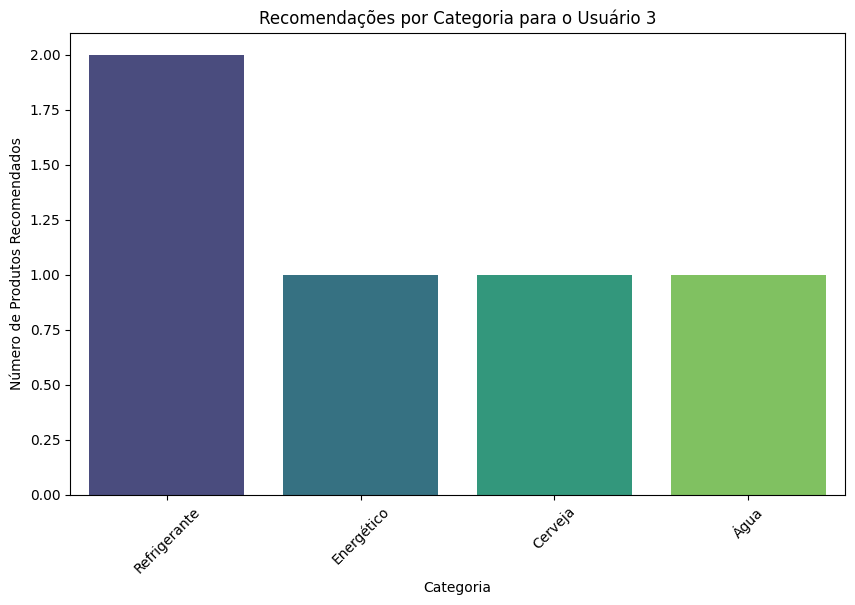

In [93]:
# Função para exibir recomendações e visualizar por categoria
def plot_recommendations(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    recommendations = recommend_hybrid_train(user_id=user_id, n_recommendations=n_recommendations,
                                             user_weight=user_weight, product_weight=product_weight)

    if recommendations.empty:
        print(f"Nenhuma recomendação disponível para o usuário {user_id}")
    else:
        # Contar o número de produtos por categoria
        category_counts = recommendations['category'].value_counts()

        # Plotar as recomendações por categoria
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
        plt.title(f"Recomendações por Categoria para o Usuário {user_id}")
        plt.xlabel("Categoria")
        plt.ylabel("Número de Produtos Recomendados")
        plt.xticks(rotation=45)
        plt.show()

# Testar a visualização para um usuário específico
plot_recommendations(user_id=3, n_recommendations=5, user_weight=0.7, product_weight=0.3)

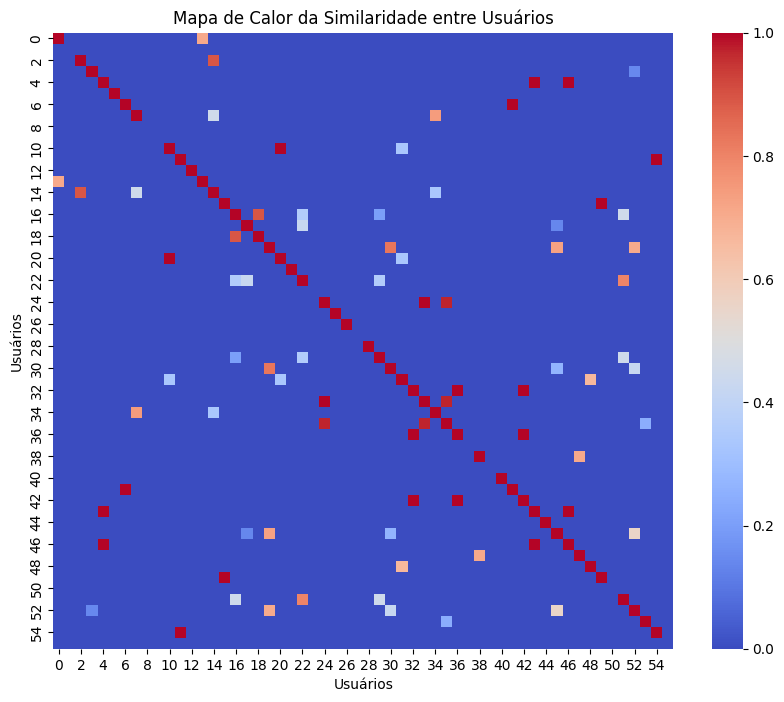

In [94]:
# Visualização da similaridade entre os usuários com heatmap
def plot_user_similarity():
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity_train, cmap="coolwarm", annot=False)
    plt.title("Mapa de Calor da Similaridade entre Usuários")
    plt.xlabel("Usuários")
    plt.ylabel("Usuários")
    plt.show()

# Testar a visualização de similaridade entre usuários
plot_user_similarity()

**Recomendações **